# Solution of faulkner-skan equations using 'Formulation - B'

#### Faulkner - Skan boundary layer equation:
$\begin{align}
f''' + \frac{(m+1)}{2}ff'' + m(1 - (f')^2) = 0
\end{align}$
where 
$$\eta  = y\left ( \sqrt\frac{U(x)}{\nu x} \right )$$
and
$$f'(\eta ) =\frac{u}{U(x)}$$

#### Boundary Conditions:
$$\eta = 0 : f(0) = f'(0) = 0$$
$$ \eta = 6 : f'(6) = 1 $$
To represent infinity for computational purposes a sufficiently large number ($\eta = 6$) is taken 



### This is the implementation of solution of faulkner skan boundary layer equation using PINNS with only one hidden Layer.

In [1]:
# importing neccery packages
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim 
import numpy as np   # Numpy
import matplotlib.pyplot as plt

#### sampling of points inside 1D domain

In [2]:
#Creation of 1D array (representing data sampling)
np.random.seed(941)
torch.manual_seed(11)
eta = np.linspace(0,6,1000)[:,None]
eta_min = eta[[0]]
eta_max = eta[[-1]]

# pde parametres
m = 0
k = 1
nu = 1.48e-5     # kinematic viscosity of air

bc = eta[[0,-1]]
f_bc = np.array([[0],
                [1]])


In [3]:
# Converting numpy array into tensors

eta = torch.from_numpy(eta).float()
eta_min = torch.from_numpy(eta_min).float()
eta_max = torch.from_numpy(eta_max).float()
bc = torch.from_numpy(bc).float()
f_bc = torch.from_numpy(f_bc).float()

#### Activation function chosen : Tanh
#### Loss reduction method : MSEloss

### Formulation of loss functions :
#### Boundary losses :
$$e_{bc1} = f(0)^2$$
$$e_{bc2} = f'(0)^2$$
$$e_{bc3} = (f'(6)-1)^2$$
$$e_{bc4} = f''(6)^2$$
$e_{bc} = e_{bc1}+e_{bc2}+e_{bc3}+e_{bc4}$

Since we have only one boundary point on either side of the domain , summantion is not used 

#### ODE Loss :
$$e_{ode} = \frac{1}{N}\sum_{i=1}^{N}\left ( f''' +\frac{(m+1)}{2}ff''+m(1-(f')^2) \right )^2$$

where N = no. of point sampled inside 1D domain
for this problem N = 1000

#### Total loss :
$$e_{total} = e_{bc} + e_{ode}$$

In [4]:
class NN(nn.Module):
    
    def __init__(self,layers):
        super().__init__()
        
        # definning the activation function
        self.activation = nn.Tanh()

        #defining the loss function
        self.loss_function = nn.MSELoss(reduction='mean')

        # defining the list of linear transformation objects which neural network applies between each layers
        self.linears = nn.ModuleList([nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)])

        self.iter = 0

        self.Lbc = []
        self.Lpde = []


    def forward(self,x):

        # A check if input data is not in tensor form
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        # min - max scaling of the data 
        x = (x -eta_min)/(eta_max-eta_min)

        for i in range(len(layers)-2):
            z = self.linears[i](x)
            x = self.activation(z)

        a = self.linears[-1](x)
        return a

    def bc_loss(self,x,y):
        
        # BC1
        x1 = x[[0]]
        y1 = y[[0]]

        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1,g1,torch.ones([x1.shape[0],1]),retain_graph = True,create_graph = True)[0]

        #BC2
        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2,g2,torch.ones([x2.shape[0],1]),retain_graph = True,create_graph = True)[0]

        loss_bc1 = self.loss_function(f1,y1) + self.loss_function(f_etab1,torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2,y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc
    
    def PDE(self,x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)

        f_eta = autograd.grad(f3,g3,torch.ones([g3.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_eta2 = autograd.grad(f_eta,g3,torch.ones([g3.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_eta3 = autograd.grad(f_eta2,g3,torch.ones([g3.shape[0],1]),create_graph = True)[0]

        # defining faulkner skan ordinary differential equation
        
        pde = f_eta3 + ((m+1)/2) * f3*f_eta2 + m*(1 -(f_eta)**2)

        loss_pde = self.loss_function(pde,torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde
    
    def loss(self,x,xb,yb):

        loss1= self.bc_loss(xb,yb)
        loss2 = self.PDE(x)

        total_loss = abs(loss1) + abs(loss2)
        return total_loss
    
    def closure(self):
        optimizer.zero_grad()

        loss = self.loss(eta,bc,f_bc)

        loss.backward()

        self.iter += 1

        if self.iter % 100 ==0:
            print(loss)
            
        return loss    
    
    def test(self,x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result,x,torch.ones([x.shape[0],1]),retain_graph = True,create_graph = True)[0]
        f_dd = autograd.grad(f_d,x,torch.ones([x.shape[0],1]),retain_graph = True,create_graph = True)[0]

        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()


        return pred_result,f_d,f_dd

In [5]:
# specification of network architecture
layers = [1,20,1]

#creating an instance of NN class
pinn = NN(layers)

params = list(pinn.parameters())

optimizer = torch.optim.LBFGS(pinn.parameters(),lr = 0.1,max_iter = 2000,
                              tolerance_grad = 1e-7,tolerance_change=1e-10,
                              history_size = 500,line_search_fn='strong_wolfe')

optimizer.step(pinn.closure)

tensor(0.0022, grad_fn=<AddBackward0>)
tensor(9.2337e-06, grad_fn=<AddBackward0>)
tensor(2.8820e-06, grad_fn=<AddBackward0>)
tensor(1.9562e-07, grad_fn=<AddBackward0>)


tensor(0.9270, grad_fn=<AddBackward0>)

461


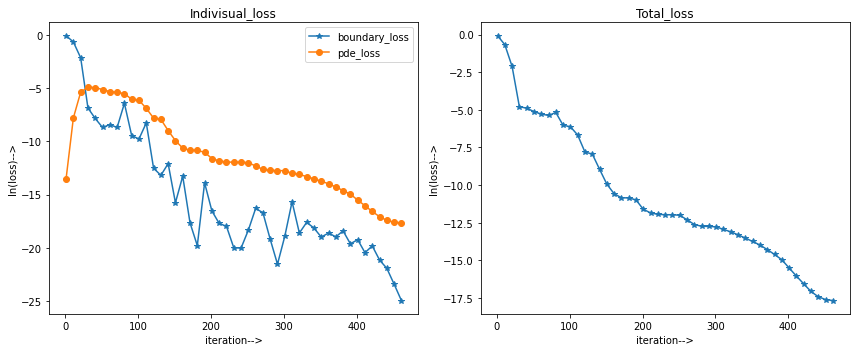

2.129944665085759e-08


In [6]:
print(pinn.iter)
Lbc_list = pinn.Lbc
Lpde_list = pinn.Lpde

plt.figure(figsize = (12,5))
plt.subplot(121)
plt.plot(np.arange(1,len(Lbc_list)+1)[::10],np.log(np.array(Lbc_list)[::10]),marker = '*',label = 'boundary_loss')
plt.plot(np.arange(1,len(Lpde_list)+1)[::10],np.log(np.array(Lpde_list)[::10]),marker = 'o',label = 'pde_loss')
plt.legend()
plt.xlabel('iteration-->')
plt.ylabel('ln(loss)-->')
plt.title('Indivisual_loss')

plt.subplot(122)
total_loss = [a + b for a, b in zip(Lbc_list, Lpde_list)]
plt.plot(np.arange(1,len(total_loss)+1)[::10],np.log(np.array(total_loss)[::10]),marker ='*')
plt.title('Total_loss')
plt.xlabel('iteration-->')
plt.ylabel('ln(loss)-->')
plt.tight_layout()
#plt.savefig(f'Loss({layers[1]}).png')
plt.show()

error = abs(total_loss[-1])
print(error)
fp,fp_d,fp_dd = pinn.test(eta)

In [7]:
eta = eta.detach().numpy()
fp = fp[:,0]
fp_d = fp_d[:,0]
fp_dd = fp_dd[:,0]
eta = eta[:,0]

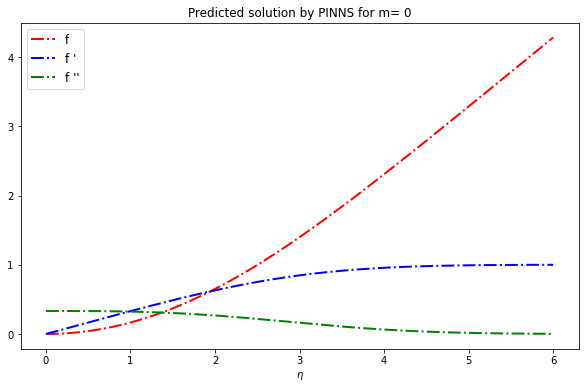

In [8]:
plt.figure(figsize =(10,6))
plt.plot(eta,fp,linestyle = '-.',label = 'f',c = 'red',linewidth = 2)
plt.plot(eta,fp_d,linestyle ='-.',label ="f '",c='blue',linewidth = 2)
plt.plot(eta,fp_dd,linestyle ='-.',label = "f ''",c = "green",linewidth = 2)
plt.title(f"Predicted solution by PINNS for m= {m}")
plt.xlabel('$\eta$')


plt.legend(fontsize = 12)

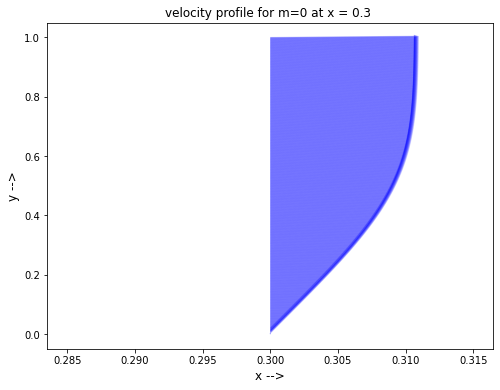

In [9]:
x_vel = 0.3
y_vel = np.linspace(0,1,1000)


u = k*x_vel**m*fp_d

v = (-1*(((m+1)/2)*nu*k*x_vel**(m-1))**0.5)*(fp + ((m-1)/(m+1))*eta*fp_d)

plt.figure(figsize = (8,6))
plt.quiver(np.ones(1000)*x_vel, y_vel, u, v, scale=3, color='b', alpha=0.2)
plt.title(f"velocity profile for m={m} at x = {x_vel} ")
plt.xlabel('x -->',fontsize = 12)
plt.ylabel('y -->',fontsize = 12)
plt.show()

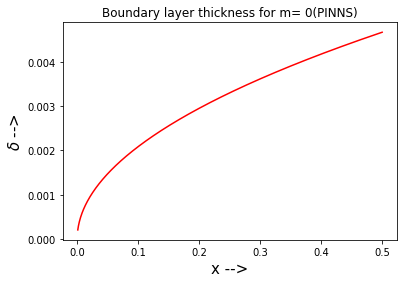

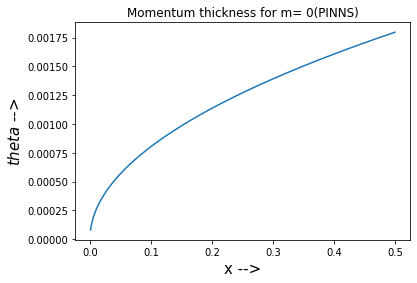

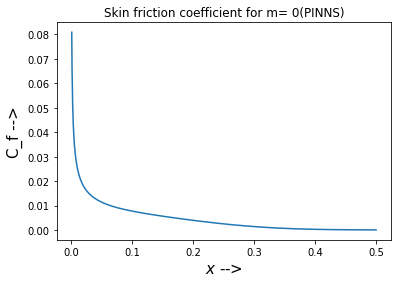

In [10]:
# defining local reynolds number
# 1e-3 is taken as starting point for plate since 0 is an singular point , it will create numerical instabilities.
x_r = np.linspace(1e-3,0.5,1000)

Re_x = (k*(x_r**m)*x_r)/nu

integral_delta = np.trapz((1-fp_d), eta)

delta = x_r*np.sqrt(1/Re_x)*integral_delta

plt.plot(x_r,delta ,c="r" )
plt.xlabel("x -->",fontsize = 15)
plt.title(f'Boundary layer thickness for m= {m}(PINNS)')
plt.ylabel('$\delta$ -->',fontsize = 15)
plt.show()

integral_theta = np.trapz((fp_d*(1-fp_d)), eta)

theta_x = x_r*np.sqrt(1/Re_x)*integral_theta

plt.plot(x_r,theta_x)
plt.xlabel("x -->",fontsize = 15)
plt.title(f'Momentum thickness for m= {m}(PINNS)')
plt.ylabel('$theta$ -->',fontsize = 15)
plt.show()

c_f = (2*fp_dd)/np.sqrt(Re_x)

plt.plot(x_r,c_f)
plt.xlabel("$x$ -->",fontsize = 15)
plt.title(f'Skin friction coefficient for m= {m}(PINNS)')
plt.ylabel('C_f -->',fontsize = 15)
plt.show()



